# Lets Load the data from Hopsworks (Feature Store)

In [8]:
import hopsworks

In [9]:
api = '*************************************************************'
project = hopsworks.login(api_key_value=api)

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/792725


In [10]:
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.


In [11]:
truck_data = fs.get_feature_group('truck_final',version=1).select_all().read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.78s) 


In [12]:
truck_data.head(3)

,unique_id,truck_id,route_id,departure_date,estimated_arrival,delay,route_avg_temp,route_avg_wind,route_description,route_avg_precip,...,mileage_mpg,fuel_type,driver_id,name,gender,age,experience,driving_style,ratings,average_speed_mph
0,4619,22126955,R-dbf62bdb,2019-01-22 07:00:00+00:00,2019-01-22 20:59:24+00:00,0,62.750000,7.5,Clear,0.000000,...,23,diesel,66882304-8,Christopher Morales,male,56,18,proactive,7,58.74
1,1455,29054232,R-85779b5e,2019-01-07 07:00:00+00:00,2019-01-07 17:24:36+00:00,1,56.666667,16.0,Moderate rain,0.033333,...,25,diesel,0c88d91e-a,John Anderson,male,49,5,conservative,8,46.17
2,7983,33788665,R-25a62039,2019-02-06 07:00:00+00:00,2019-02-06 20:27:00+00:00,0,26.000000,11.5,Clear,0.000000,...,25,diesel,36cd9bf7-c,Ryan Clayton,male,48,10,conservative,7,47.36


In [13]:
hopsworks.logout()

Connection closed.


# Data Preprocessing

In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
import pickle

import warnings
warnings.filterwarnings('ignore')

In [15]:
truck_data.columns

Index(['unique_id', 'truck_id', 'route_id', 'departure_date',
       'estimated_arrival', 'delay', 'route_avg_temp', 'route_avg_wind',
       'route_description', 'route_avg_precip', 'route_avg_humidity',
       'route_avg_visibility', 'route_avg_pressure', 'origin_id',
       'origin_avg_temp', 'origin_avg_wind', 'origin_description',
       'origin_avg_precip', 'origin_avg_humidity', 'origin_avg_visibility',
       'origin_avg_pressure', 'destination_id', 'dest_avg_temp',
       'dest_avg_wind', 'dest_description', 'dest_avg_precip',
       'dest_avg_humidity', 'dest_avg_visibility', 'dest_avg_pressure',
       'avg_nov', 'accident', 'truck_age', 'load_capacity_pounds',
       'mileage_mpg', 'fuel_type', 'driver_id', 'name', 'gender', 'age',
       'experience', 'driving_style', 'ratings', 'average_speed_mph'],
      dtype='object')

In [16]:
num_cols = ['route_avg_temp', 'route_avg_wind', 'route_avg_precip', 'route_avg_humidity','route_avg_visibility', 
            'route_avg_pressure','origin_avg_temp', 'origin_avg_wind','origin_avg_precip', 'origin_avg_humidity', 
            'origin_avg_visibility','origin_avg_pressure', 'dest_avg_temp','dest_avg_wind','dest_avg_precip',
            'dest_avg_humidity', 'dest_avg_visibility', 'dest_avg_pressure','avg_nov', 'accident', 'truck_age', 
            'load_capacity_pounds','mileage_mpg','age','experience', 'ratings', 'average_speed_mph']

cat_cols = ['route_description','origin_description','dest_description','fuel_type','gender','driving_style']

target = ['delay']

## Train Test Split

In [17]:
truck_data['departure_date'].max()

Timestamp('2019-02-12 07:00:00+0000', tz='UTC')

In [18]:
truck_data['departure_date'].min()

Timestamp('2019-01-01 07:00:00+0000', tz='UTC')

In [19]:
train_data = truck_data[truck_data['departure_date']<pd.Timestamp('2019-02-06',tz='UTC')]

In [20]:
test_data = truck_data[truck_data['departure_date']>=pd.Timestamp('2019-02-06',tz='UTC')]

In [21]:
train_data.shape, test_data.shape

((10088, 43), (2220, 43))

In [22]:
x_train,y_train = train_data[num_cols+cat_cols], train_data[target]
x_test,y_test = test_data[num_cols+cat_cols], test_data[target]

In [23]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((10088, 33), (2220, 33), (10088, 1), (2220, 1))

In [24]:
x_train.reset_index(drop=True,inplace=True)
x_test.reset_index(drop=True,inplace=True)

In [25]:
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

## Missing Value Treatment

In [26]:
x_train.isnull().sum()

route_avg_temp             0
route_avg_wind             0
route_avg_precip           0
route_avg_humidity         0
route_avg_visibility       0
route_avg_pressure         0
origin_avg_temp            0
origin_avg_wind            0
origin_avg_precip          0
origin_avg_humidity        0
origin_avg_visibility      0
origin_avg_pressure        0
dest_avg_temp              0
dest_avg_wind              0
dest_avg_precip            0
dest_avg_humidity          0
dest_avg_visibility        0
dest_avg_pressure          0
avg_nov                    0
accident                   0
truck_age                  0
load_capacity_pounds     492
mileage_mpg                0
age                        0
experience                 0
ratings                    0
average_speed_mph          0
route_description          0
origin_description         0
dest_description           0
fuel_type                  0
gender                     0
driving_style              0
dtype: int64

In [27]:
x_train['load_capacity_pounds'].value_counts()

load_capacity_pounds
3000.0     2376
15000.0    2138
4000.0     1560
6000.0     1537
10000.0    1277
20000.0     708
Name: count, dtype: int64

In [28]:
# Lets go with mode as there only few categories
load_capacity_mode =  x_train['load_capacity_pounds'].mode()[0]

In [29]:
load_capacity_mode

3000.0

In [30]:
x_train['load_capacity_pounds'].fillna(load_capacity_mode,inplace=True)
x_test['load_capacity_pounds'].fillna(load_capacity_mode,inplace=True)

In [31]:
x_train.isnull().sum().sum()

0

In [32]:
x_test.isnull().sum().sum()

0

## Encoding

In [33]:
encoder = OneHotEncoder(sparse_output=False)

In [34]:
encoder.fit(x_train[cat_cols])

OneHotEncoder(sparse_output=False)

In [35]:
encoded_train = pd.DataFrame(encoder.transform(x_train[cat_cols]),columns=encoder.get_feature_names_out(cat_cols))
encoded_test = pd.DataFrame(encoder.transform(x_test[cat_cols]),columns=encoder.get_feature_names_out(cat_cols))

In [36]:
x_train = pd.concat((x_train,encoded_train),axis=1)
x_test = pd.concat((x_test,encoded_test),axis=1)

In [37]:
x_train.shape

(10088, 115)

In [38]:
x_test.shape

(2220, 115)

In [39]:
x_train.drop(columns=cat_cols,inplace=True)
x_test.drop(columns=cat_cols,inplace=True)

In [40]:
with open('encoder.pkl','wb') as file:
    pickle.dump(encoder,file)

## Feature Scaling

In [41]:
scalar = StandardScaler()

In [42]:
scalar.fit(x_train[num_cols])

StandardScaler()

In [43]:
x_train[num_cols] = scalar.transform(x_train[num_cols])
x_test[num_cols] = scalar.transform(x_test[num_cols])

In [44]:
x_train.head(3)

,route_avg_temp,route_avg_wind,route_avg_precip,route_avg_humidity,route_avg_visibility,route_avg_pressure,origin_avg_temp,origin_avg_wind,origin_avg_precip,origin_avg_humidity,...,dest_description_Sunny,fuel_type_,fuel_type_diesel,fuel_type_gas,gender_female,gender_male,gender_unknown,driving_style_conservative,driving_style_proactive,driving_style_unknown
0,0.382168,-0.187298,-0.304933,1.034587,-1.461113,-0.602208,-0.428865,-0.859093,-0.641325,-0.286812,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.080671,2.568870,1.523798,0.995290,-1.110793,-2.290764,0.058924,1.529754,-0.641325,-1.287667,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.933771,1.012446,-0.304933,-1.878968,0.220424,-0.926804,-1.285618,-1.634805,-0.641325,0.997884,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [45]:
x_test.head(3)

,route_avg_temp,route_avg_wind,route_avg_precip,route_avg_humidity,route_avg_visibility,route_avg_pressure,origin_avg_temp,origin_avg_wind,origin_avg_precip,origin_avg_humidity,...,dest_description_Sunny,fuel_type_,fuel_type_diesel,fuel_type_gas,gender_female,gender_male,gender_unknown,driving_style_conservative,driving_style_proactive,driving_style_unknown
0,-2.413885,1.109723,-0.304933,-0.144308,0.640809,-0.061214,-0.173564,-0.782959,2.544301,0.557621,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-2.160275,-0.457510,-0.304933,0.950380,0.640809,1.643737,-0.482174,0.825639,1.588613,0.891946,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.156754,-0.133255,-0.304933,0.568643,0.290488,-0.454664,-0.081623,1.160887,-0.145783,0.066377,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [46]:
x_train.shape

(10088, 109)

In [47]:
x_test.shape

(2220, 109)

In [48]:
with open('scalar.pkl','wb') as file:
    pickle.dump(scalar,file)

# Predictive Modelling

## wandb (Weights and Biases) : Model Experimentation and registry

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,roc_curve
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score,cohen_kappa_score

#import joblib
import wandb

In [50]:
# Since the target class is imbalanced lets assign weights to classes
# weigth_class = n_obs / (no_of_classes * n_obs_class)

In [51]:
weight = y_train.shape[0]/(2*y_train.value_counts()[0]),y_train.shape[0]/(2*y_train.value_counts()[1]) 

In [52]:
weight_dict = {k:w for k,w in zip(range(2),weight)}

In [53]:
weight_dict

{0: 0.7572436571085422, 1: 1.4718412605777649}

## Logistic Regression

In [54]:
wandb.login()

wandb: Currently logged in as: gauravsiwalde (gauravsiwalde-freelance). Use `wandb login --relogin` to force relogin


True

In [48]:
def train_logistic_model(xtrain,ytrain,xtest,ytest):
    with wandb.init(project='truck_delay_prediction') as run:
        config = wandb.config
        params = {'solver':'liblinear','random_state':2,'class_weight':weight_dict}

        model = LogisticRegression(**params)
        model.fit(xtrain,ytrain)

         # train prediction
        pred_h_train = model.predict(xtrain)
        pred_s_train = model.predict_proba(xtrain)


        # test prediction
        pred_h_test = model.predict(xtest)
        pred_s_test = model.predict_proba(xtest)

        print('confusion matrix:\n',confusion_matrix(ytest,pred_h_test))
        print('classification report:\n',classification_report(ytest,pred_h_test))

        fpr,tpr,thres = roc_curve(ytest,pred_s_test[:,1])
        plt.title(f'ROC AUC: {round(roc_auc_score(ytest,pred_s_test[:,1]),2)}')
        plt.plot([0,1],[0,1],ls='--',color='red')
        plt.plot(fpr,tpr)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.show()

        wandb.log({'train_recall':recall_score(ytrain,pred_h_train)})
        wandb.log({'test_recall':recall_score(ytest,pred_h_test)})
        wandb.log({'train_F1':f1_score(ytrain,pred_h_train)})
        wandb.log({'test_F1':f1_score(ytest,pred_h_test)})

        wandb.sklearn.plot_classifier(model,xtrain,xtest,ytrain,ytest,pred_h_test,pred_s_test,labels=None,
                                      model_name='Logistic_Regression',feature_names=xtrain.columns)
        
        model_artifact = wandb.Artifact(name='Logistic_Regression',type='model',metadata=dict(config))

        
        with open('truck_classification_LogR.pkl','wb') as file:
            pickle.dump(model,file)
        model_artifact.add_file('truck_classification_LogR.pkl')

        wandb.save('truck_classification_LogR.pkl')
        wandb.log_artifact(model_artifact)

confusion matrix:
 [[1098  255]
 [ 317  550]]
classification report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.79      1353
           1       0.68      0.63      0.66       867

    accuracy                           0.74      2220
   macro avg       0.73      0.72      0.73      2220
weighted avg       0.74      0.74      0.74      2220



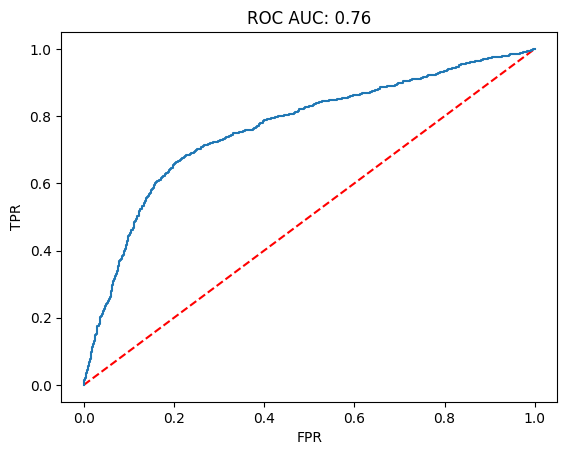

wandb: 
wandb: Plotting Logistic_Regression.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.65789
test_recall,0.63437
train_F1,0.56125
train_recall,0.63904


In [49]:
train_logistic_model(x_train,y_train,x_test,y_test)

### Decision Tree

In [50]:
def train_decisiontree_model(xtrain=x_train,ytrain=y_train,xtest=x_test,ytest=y_test):
    with wandb.init(project='truck_delay_prediction') as run:
        config = wandb.config

        model = DecisionTreeClassifier(max_depth=config['max_depth'],class_weight=weight_dict,
                                      max_leaf_nodes=config['max_leaves'])
        model.fit(xtrain,ytrain)

         # train prediction
        pred_h_train = model.predict(xtrain)
        pred_s_train = model.predict_proba(xtrain)


        # test prediction
        pred_h_test = model.predict(xtest)
        pred_s_test = model.predict_proba(xtest)

        print('confusion matrix:\n',confusion_matrix(ytest,pred_h_test))
        print('classification report:\n',classification_report(ytest,pred_h_test))

        fpr,tpr,thres = roc_curve(ytest,pred_s_test[:,1])
        plt.title(f'ROC AUC: {round(roc_auc_score(ytest,pred_s_test[:,1]),2)}')
        plt.plot([0,1],[0,1],ls='--',color='red')
        plt.plot(fpr,tpr)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.show()

        wandb.log({'train_recall':recall_score(ytrain,pred_h_train)})
        wandb.log({'test_recall':recall_score(ytest,pred_h_test)})
        wandb.log({'train_F1':f1_score(ytrain,pred_h_train)})
        wandb.log({'test_F1':f1_score(ytest,pred_h_test)})

        wandb.sklearn.plot_classifier(model,xtrain,xtest,ytrain,ytest,pred_h_test,pred_s_test,labels=None,
                                      model_name='Decision_Tree',feature_names=xtrain.columns)
        
        model_artifact = wandb.Artifact(name='Decision_Tree',type='model',metadata=dict(config))

        with open('truck_classification_DT.pkl','wb') as file:
            pickle.dump(model,file)
        model_artifact.add_file('truck_classification_DT.pkl')

        wandb.save('truck_classification_DT.pkl')
        wandb.log_artifact(model_artifact)

In [51]:
sweep_configs = {
    "method": "grid",
    "metric": {
        "name": "f1_score",
        "goal": "maximize"},
    "parameters": {
        "max_depth": {"values": [4,5,6,7,8,9,11]},
        "max_leaves": {"values": [5,10,15,20]}}
}
# Then we initialize the sweep and run the sweep agent.

Create sweep with ID: asgvjm41
Sweep URL: https://wandb.ai/gauravsiwalde-freelance/truck_delay_prediction/sweeps/asgvjm41


wandb: Agent Starting Run: 1ofpqxp3 with config:
wandb: 	max_depth: 4
wandb: 	max_leaves: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[976 377]
 [297 570]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.74      1353
           1       0.60      0.66      0.63       867

    accuracy                           0.70      2220
   macro avg       0.68      0.69      0.69      2220
weighted avg       0.70      0.70      0.70      2220



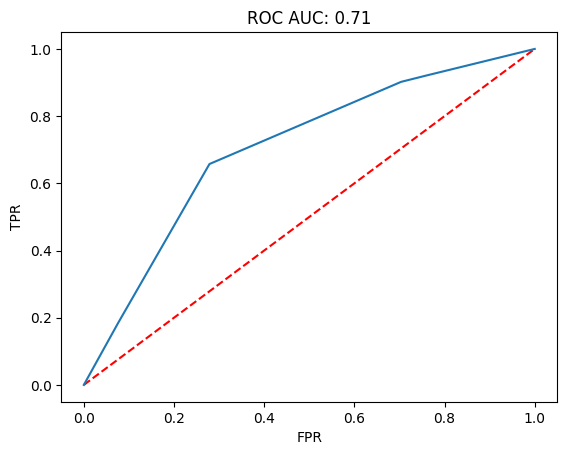

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.62845
test_recall,0.65744
train_F1,0.54281
train_recall,0.65859


wandb: Agent Starting Run: ggrvdtj8 with config:
wandb: 	max_depth: 4
wandb: 	max_leaves: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1065  288]
 [ 308  559]]
classification report:
               precision    recall  f1-score   support

           0       0.78      0.79      0.78      1353
           1       0.66      0.64      0.65       867

    accuracy                           0.73      2220
   macro avg       0.72      0.72      0.72      2220
weighted avg       0.73      0.73      0.73      2220



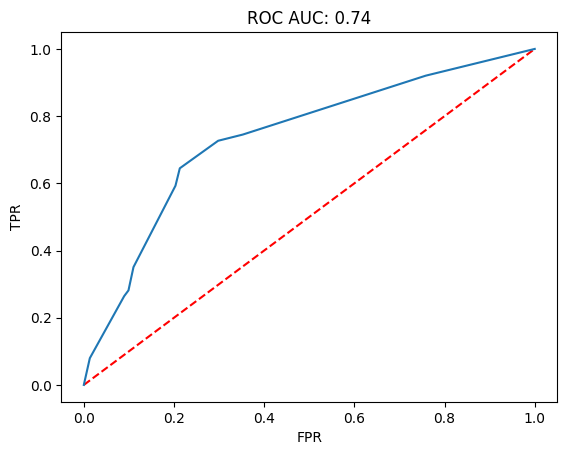

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.65228
test_recall,0.64475
train_F1,0.55036
train_recall,0.60665


wandb: Agent Starting Run: tosh7kcy with config:
wandb: 	max_depth: 4
wandb: 	max_leaves: 15
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1048  305]
 [ 309  558]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77      1353
           1       0.65      0.64      0.65       867

    accuracy                           0.72      2220
   macro avg       0.71      0.71      0.71      2220
weighted avg       0.72      0.72      0.72      2220



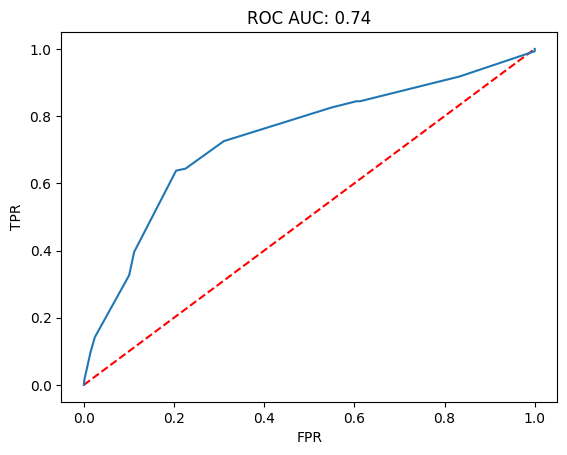

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.64509
test_recall,0.6436
train_F1,0.55487
train_recall,0.61453


wandb: Agent Starting Run: 95nejke1 with config:
wandb: 	max_depth: 4
wandb: 	max_leaves: 20
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1048  305]
 [ 309  558]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77      1353
           1       0.65      0.64      0.65       867

    accuracy                           0.72      2220
   macro avg       0.71      0.71      0.71      2220
weighted avg       0.72      0.72      0.72      2220



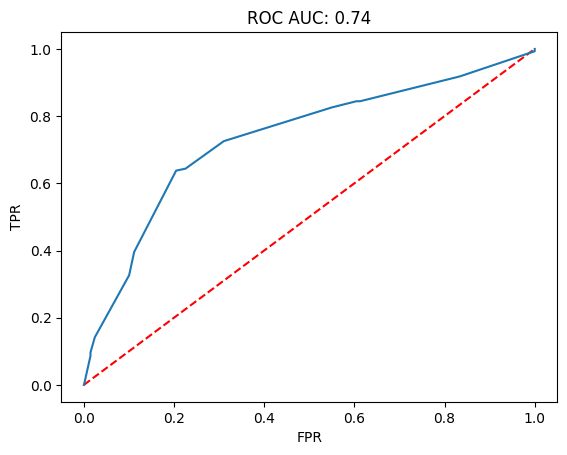

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.64509
test_recall,0.6436
train_F1,0.55487
train_recall,0.61453


wandb: Agent Starting Run: l31ujftw with config:
wandb: 	max_depth: 5
wandb: 	max_leaves: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[976 377]
 [297 570]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.74      1353
           1       0.60      0.66      0.63       867

    accuracy                           0.70      2220
   macro avg       0.68      0.69      0.69      2220
weighted avg       0.70      0.70      0.70      2220



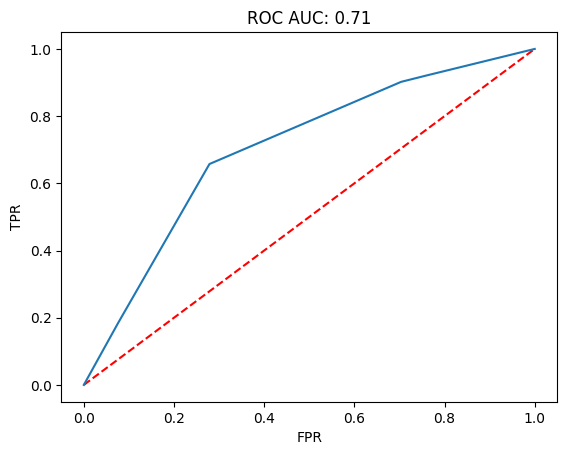

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.62845
test_recall,0.65744
train_F1,0.54281
train_recall,0.65859


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 27rj56dv with config:
wandb: 	max_depth: 5
wandb: 	max_leaves: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1109  244]
 [ 323  544]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.82      0.80      1353
           1       0.69      0.63      0.66       867

    accuracy                           0.74      2220
   macro avg       0.73      0.72      0.73      2220
weighted avg       0.74      0.74      0.74      2220



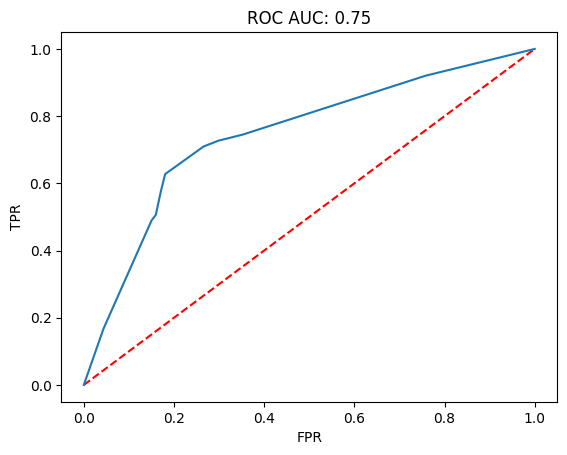

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.6574
test_recall,0.62745
train_F1,0.55196
train_recall,0.5944


wandb: Agent Starting Run: p6gwnci6 with config:
wandb: 	max_depth: 5
wandb: 	max_leaves: 15
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1202  151]
 [ 353  514]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.89      0.83      1353
           1       0.77      0.59      0.67       867

    accuracy                           0.77      2220
   macro avg       0.77      0.74      0.75      2220
weighted avg       0.77      0.77      0.77      2220



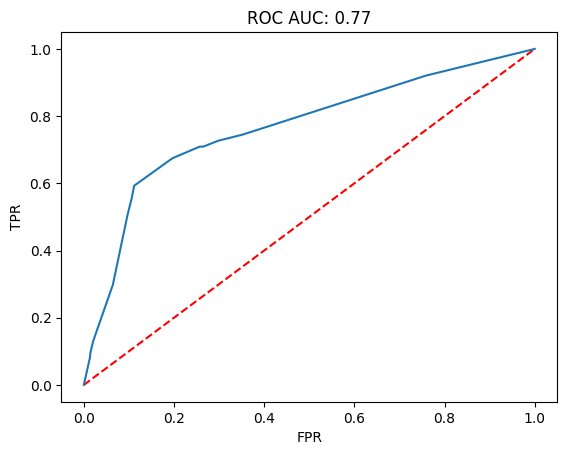

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.67102
test_recall,0.59285
train_F1,0.55648
train_recall,0.55705


wandb: Agent Starting Run: 3tl5fbmt with config:
wandb: 	max_depth: 5
wandb: 	max_leaves: 20
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1138  215]
 [ 315  552]]
classification report:
               precision    recall  f1-score   support

           0       0.78      0.84      0.81      1353
           1       0.72      0.64      0.68       867

    accuracy                           0.76      2220
   macro avg       0.75      0.74      0.74      2220
weighted avg       0.76      0.76      0.76      2220



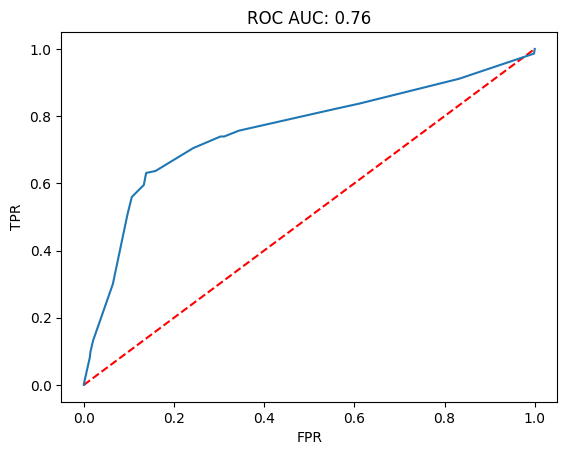

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.67564
test_recall,0.63668
train_F1,0.56845
train_recall,0.60461


wandb: Agent Starting Run: nqj8r0dr with config:
wandb: 	max_depth: 6
wandb: 	max_leaves: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[976 377]
 [297 570]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.74      1353
           1       0.60      0.66      0.63       867

    accuracy                           0.70      2220
   macro avg       0.68      0.69      0.69      2220
weighted avg       0.70      0.70      0.70      2220



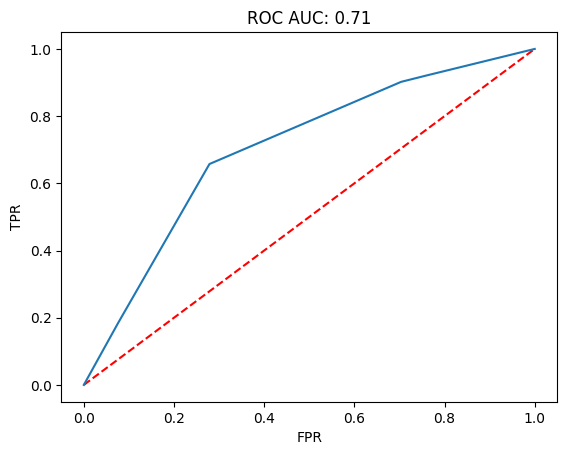

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.62845
test_recall,0.65744
train_F1,0.54281
train_recall,0.65859


wandb: Agent Starting Run: ge55a45u with config:
wandb: 	max_depth: 6
wandb: 	max_leaves: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1109  244]
 [ 323  544]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.82      0.80      1353
           1       0.69      0.63      0.66       867

    accuracy                           0.74      2220
   macro avg       0.73      0.72      0.73      2220
weighted avg       0.74      0.74      0.74      2220



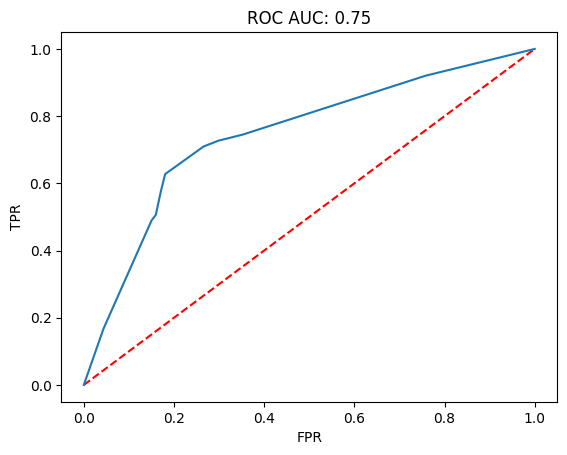

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.6574
test_recall,0.62745
train_F1,0.55196
train_recall,0.5944


wandb: Agent Starting Run: w7g7ship with config:
wandb: 	max_depth: 6
wandb: 	max_leaves: 15
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1200  153]
 [ 350  517]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.89      0.83      1353
           1       0.77      0.60      0.67       867

    accuracy                           0.77      2220
   macro avg       0.77      0.74      0.75      2220
weighted avg       0.77      0.77      0.77      2220



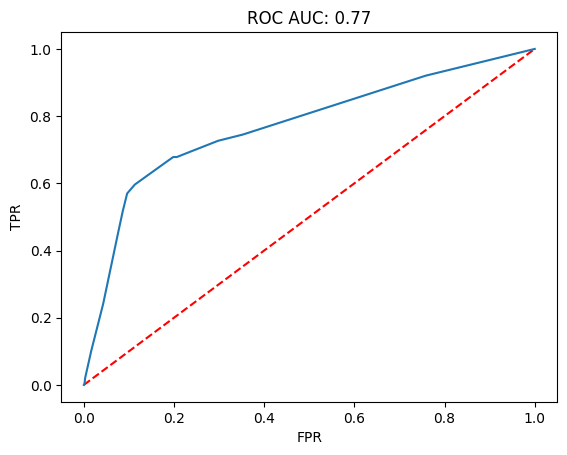

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.67274
test_recall,0.59631
train_F1,0.56005
train_recall,0.56405


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: td6hm2cp with config:
wandb: 	max_depth: 6
wandb: 	max_leaves: 20
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1164  189]
 [ 319  548]]
classification report:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82      1353
           1       0.74      0.63      0.68       867

    accuracy                           0.77      2220
   macro avg       0.76      0.75      0.75      2220
weighted avg       0.77      0.77      0.77      2220



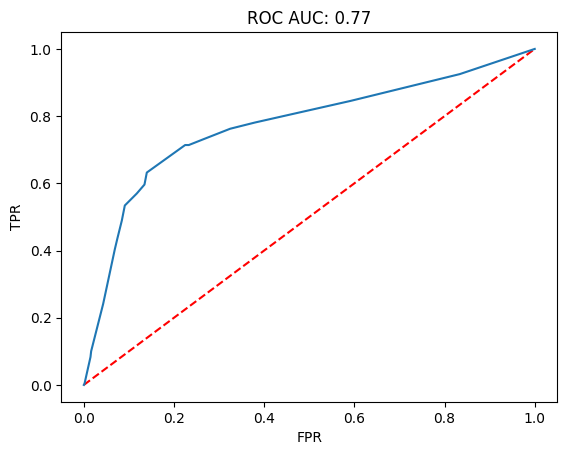

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.68329
test_recall,0.63206
train_F1,0.56976
train_recall,0.59819


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zdsp2dix with config:
wandb: 	max_depth: 7
wandb: 	max_leaves: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[976 377]
 [297 570]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.74      1353
           1       0.60      0.66      0.63       867

    accuracy                           0.70      2220
   macro avg       0.68      0.69      0.69      2220
weighted avg       0.70      0.70      0.70      2220



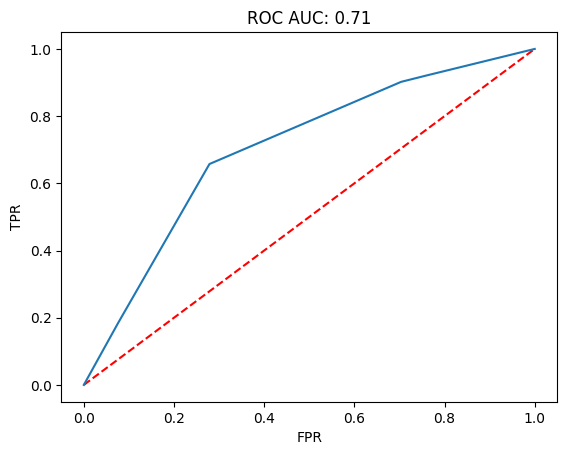

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.62845
test_recall,0.65744
train_F1,0.54281
train_recall,0.65859


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hgur0hs4 with config:
wandb: 	max_depth: 7
wandb: 	max_leaves: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1109  244]
 [ 323  544]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.82      0.80      1353
           1       0.69      0.63      0.66       867

    accuracy                           0.74      2220
   macro avg       0.73      0.72      0.73      2220
weighted avg       0.74      0.74      0.74      2220



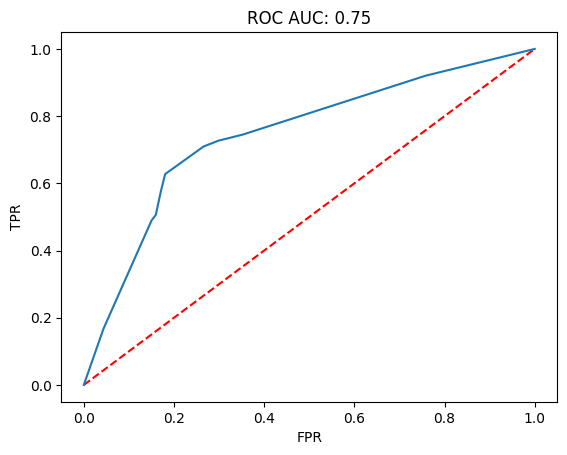

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.6574
test_recall,0.62745
train_F1,0.55196
train_recall,0.5944


wandb: Agent Starting Run: 29s2ksuz with config:
wandb: 	max_depth: 7
wandb: 	max_leaves: 15
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1201  152]
 [ 357  510]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.89      0.83      1353
           1       0.77      0.59      0.67       867

    accuracy                           0.77      2220
   macro avg       0.77      0.74      0.75      2220
weighted avg       0.77      0.77      0.76      2220



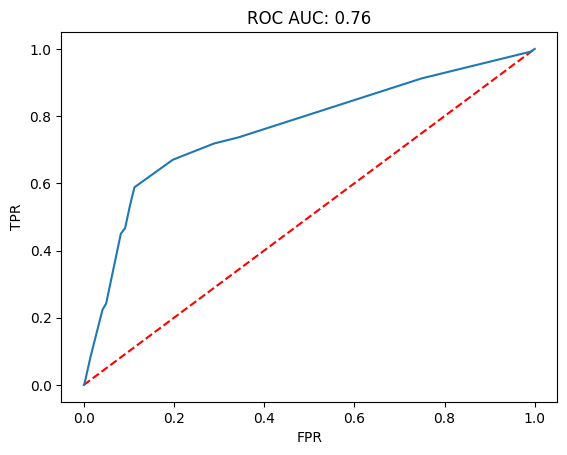

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.6671
test_recall,0.58824
train_F1,0.56311
train_recall,0.56434


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1po2mbpw with config:
wandb: 	max_depth: 7
wandb: 	max_leaves: 20
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1213  140]
 [ 359  508]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83      1353
           1       0.78      0.59      0.67       867

    accuracy                           0.78      2220
   macro avg       0.78      0.74      0.75      2220
weighted avg       0.78      0.78      0.77      2220



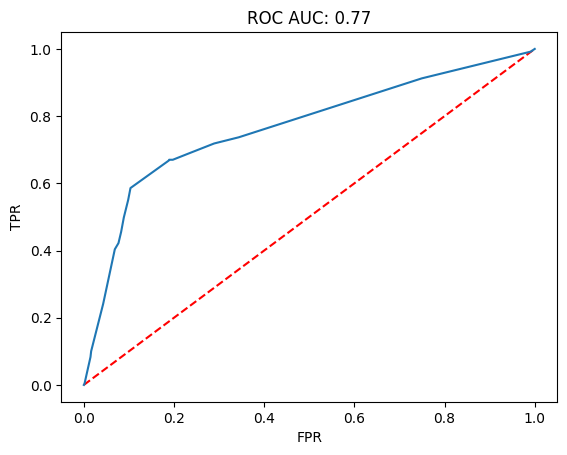

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.67063
test_recall,0.58593
train_F1,0.56405
train_recall,0.54479


wandb: Agent Starting Run: ydub54no with config:
wandb: 	max_depth: 8
wandb: 	max_leaves: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[976 377]
 [297 570]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.74      1353
           1       0.60      0.66      0.63       867

    accuracy                           0.70      2220
   macro avg       0.68      0.69      0.69      2220
weighted avg       0.70      0.70      0.70      2220



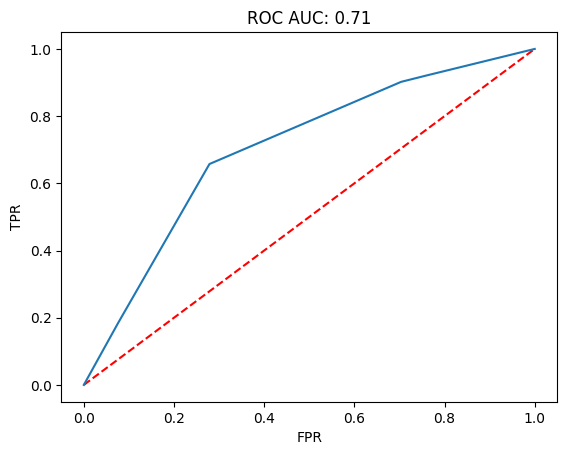

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.62845
test_recall,0.65744
train_F1,0.54281
train_recall,0.65859


wandb: Agent Starting Run: ebyyj1wg with config:
wandb: 	max_depth: 8
wandb: 	max_leaves: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1109  244]
 [ 323  544]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.82      0.80      1353
           1       0.69      0.63      0.66       867

    accuracy                           0.74      2220
   macro avg       0.73      0.72      0.73      2220
weighted avg       0.74      0.74      0.74      2220



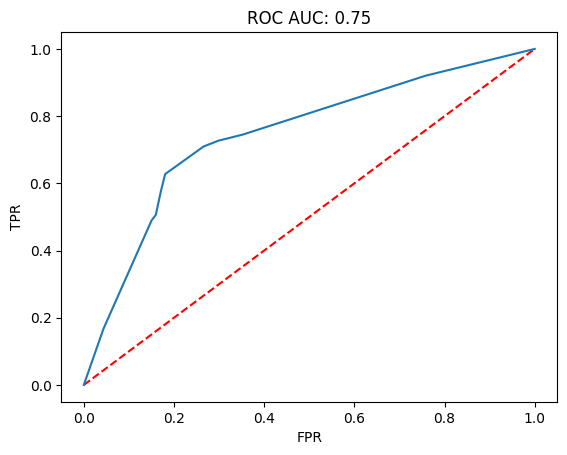

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.6574
test_recall,0.62745
train_F1,0.55196
train_recall,0.5944


wandb: Agent Starting Run: 4bfer1av with config:
wandb: 	max_depth: 8
wandb: 	max_leaves: 15
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1201  152]
 [ 357  510]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.89      0.83      1353
           1       0.77      0.59      0.67       867

    accuracy                           0.77      2220
   macro avg       0.77      0.74      0.75      2220
weighted avg       0.77      0.77      0.76      2220



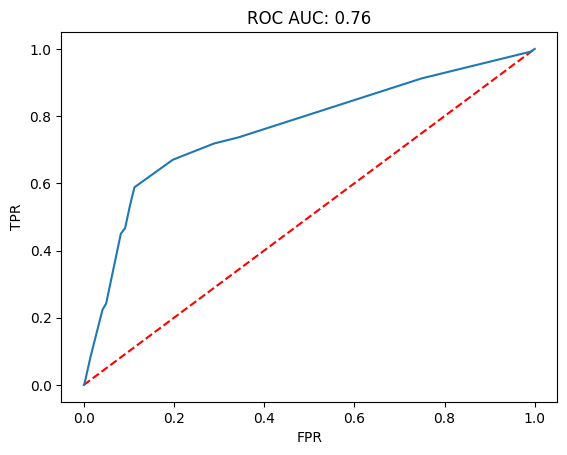

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.6671
test_recall,0.58824
train_F1,0.56311
train_recall,0.56434


wandb: Agent Starting Run: eoiyb8zb with config:
wandb: 	max_depth: 8
wandb: 	max_leaves: 20
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1213  140]
 [ 359  508]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83      1353
           1       0.78      0.59      0.67       867

    accuracy                           0.78      2220
   macro avg       0.78      0.74      0.75      2220
weighted avg       0.78      0.78      0.77      2220



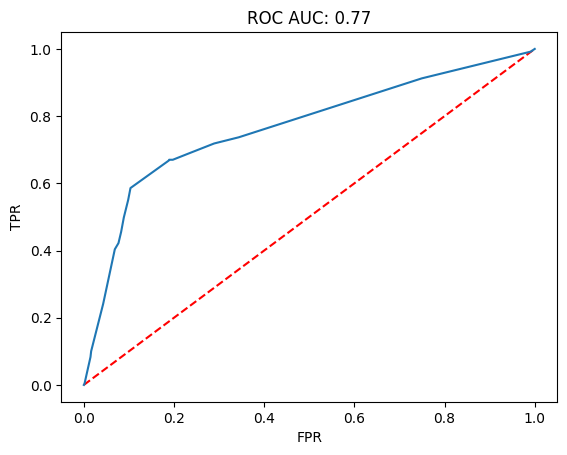

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.67063
test_recall,0.58593
train_F1,0.56405
train_recall,0.54479


wandb: Agent Starting Run: cvq2xexs with config:
wandb: 	max_depth: 9
wandb: 	max_leaves: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[976 377]
 [297 570]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.74      1353
           1       0.60      0.66      0.63       867

    accuracy                           0.70      2220
   macro avg       0.68      0.69      0.69      2220
weighted avg       0.70      0.70      0.70      2220



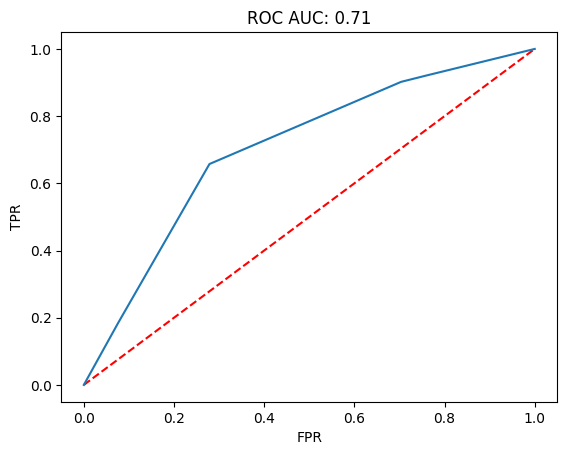

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.62845
test_recall,0.65744
train_F1,0.54281
train_recall,0.65859


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hd8m1nzh with config:
wandb: 	max_depth: 9
wandb: 	max_leaves: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1109  244]
 [ 323  544]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.82      0.80      1353
           1       0.69      0.63      0.66       867

    accuracy                           0.74      2220
   macro avg       0.73      0.72      0.73      2220
weighted avg       0.74      0.74      0.74      2220



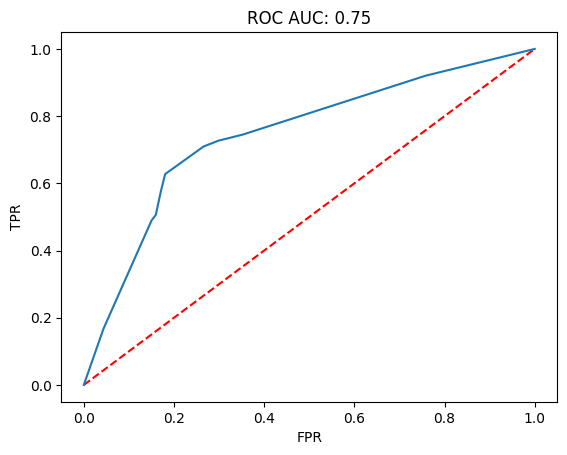

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.6574
test_recall,0.62745
train_F1,0.55196
train_recall,0.5944


wandb: Agent Starting Run: s92c5q9b with config:
wandb: 	max_depth: 9
wandb: 	max_leaves: 15
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1201  152]
 [ 357  510]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.89      0.83      1353
           1       0.77      0.59      0.67       867

    accuracy                           0.77      2220
   macro avg       0.77      0.74      0.75      2220
weighted avg       0.77      0.77      0.76      2220



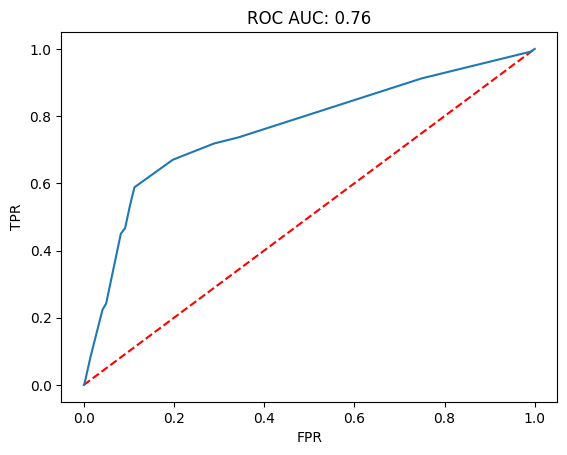

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.6671
test_recall,0.58824
train_F1,0.56311
train_recall,0.56434


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kfsvi1xc with config:
wandb: 	max_depth: 9
wandb: 	max_leaves: 20
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1213  140]
 [ 359  508]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83      1353
           1       0.78      0.59      0.67       867

    accuracy                           0.78      2220
   macro avg       0.78      0.74      0.75      2220
weighted avg       0.78      0.78      0.77      2220



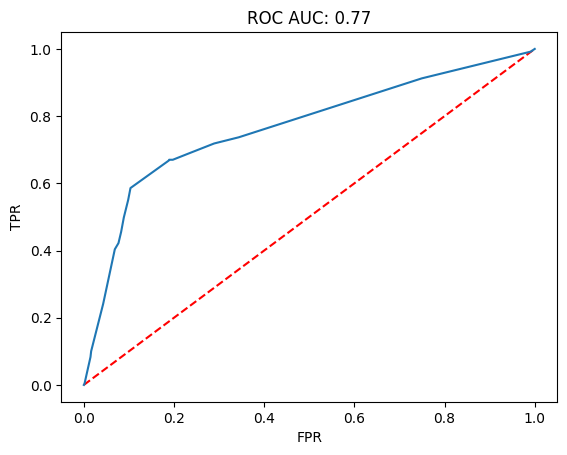

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.67063
test_recall,0.58593
train_F1,0.56405
train_recall,0.54479


wandb: Agent Starting Run: 0muw9jb5 with config:
wandb: 	max_depth: 11
wandb: 	max_leaves: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[976 377]
 [297 570]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.74      1353
           1       0.60      0.66      0.63       867

    accuracy                           0.70      2220
   macro avg       0.68      0.69      0.69      2220
weighted avg       0.70      0.70      0.70      2220



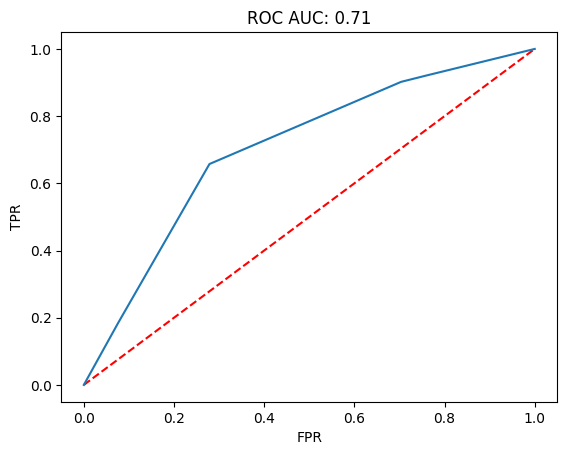

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.62845
test_recall,0.65744
train_F1,0.54281
train_recall,0.65859


wandb: Agent Starting Run: hc3p7n3f with config:
wandb: 	max_depth: 11
wandb: 	max_leaves: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1109  244]
 [ 323  544]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.82      0.80      1353
           1       0.69      0.63      0.66       867

    accuracy                           0.74      2220
   macro avg       0.73      0.72      0.73      2220
weighted avg       0.74      0.74      0.74      2220



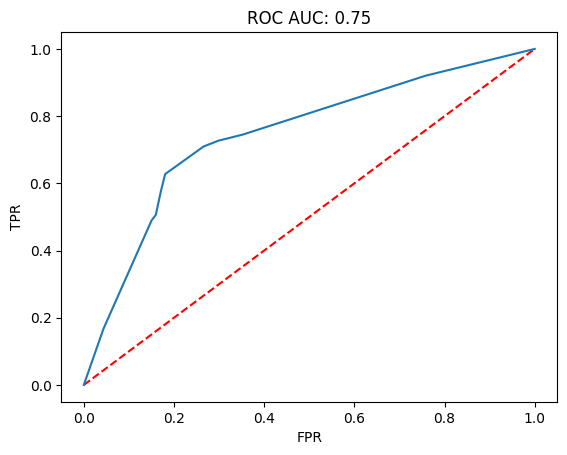

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.6574
test_recall,0.62745
train_F1,0.55196
train_recall,0.5944


wandb: Agent Starting Run: bwxq4r5l with config:
wandb: 	max_depth: 11
wandb: 	max_leaves: 15
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1201  152]
 [ 357  510]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.89      0.83      1353
           1       0.77      0.59      0.67       867

    accuracy                           0.77      2220
   macro avg       0.77      0.74      0.75      2220
weighted avg       0.77      0.77      0.76      2220



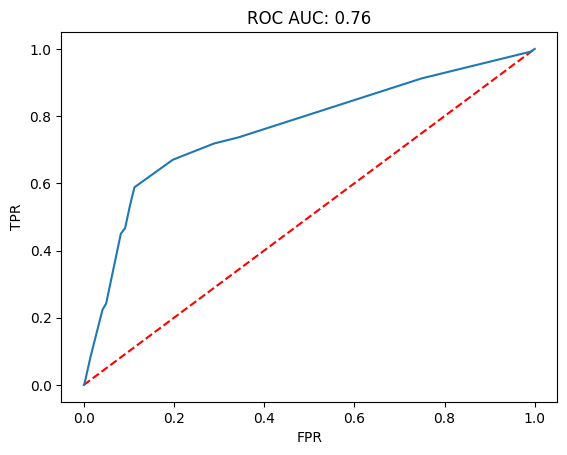

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.6671
test_recall,0.58824
train_F1,0.56311
train_recall,0.56434


wandb: Agent Starting Run: gxurgoqj with config:
wandb: 	max_depth: 11
wandb: 	max_leaves: 20
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1213  140]
 [ 359  508]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83      1353
           1       0.78      0.59      0.67       867

    accuracy                           0.78      2220
   macro avg       0.78      0.74      0.75      2220
weighted avg       0.78      0.78      0.77      2220



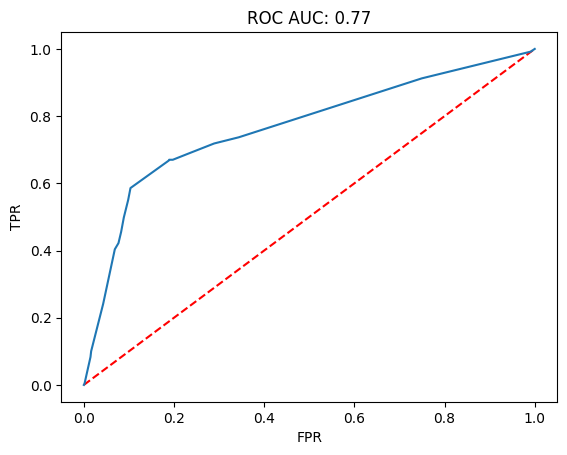

wandb: 
wandb: Plotting Decision_Tree.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.67063
test_recall,0.58593
train_F1,0.56405
train_recall,0.54479


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [52]:
sweep_id = wandb.sweep(
    sweep=sweep_configs,
    project='truck_delay_prediction')



wandb.agent(
    project='truck_delay_prediction',
    sweep_id=sweep_id,
    function=train_decisiontree_model
)

### Random Forest

In [53]:
def train_rf_model(xtrain=x_train,ytrain=y_train,xtest=x_test,ytest=y_test):
    with wandb.init(project='truck_delay_prediction') as run:
        config = wandb.config

        model = RandomForestClassifier(n_estimators=config['estimators'],max_depth=config['max_depth'],
                                       max_leaf_nodes=config['max_leaves'],class_weight=weight_dict,max_features=0.7)
        model.fit(xtrain,ytrain)

         # train prediction
        pred_h_train = model.predict(xtrain)
        pred_s_train = model.predict_proba(xtrain)


        # test prediction
        pred_h_test = model.predict(xtest)
        pred_s_test = model.predict_proba(xtest)

        print('confusion matrix:\n',confusion_matrix(ytest,pred_h_test))
        print('classification report:\n',classification_report(ytest,pred_h_test))

        fpr,tpr,thres = roc_curve(ytest,pred_s_test[:,1])
        print(f'ROC AUC: {round(roc_auc_score(ytest,pred_s_test[:,1]),2)}')

        wandb.log({'train_recall':recall_score(ytrain,pred_h_train)})
        wandb.log({'test_recall':recall_score(ytest,pred_h_test)})
        wandb.log({'train_F1':f1_score(ytrain,pred_h_train)})
        wandb.log({'test_F1':f1_score(ytest,pred_h_test)})

        wandb.sklearn.plot_classifier(model,xtrain,xtest,ytrain,ytest,pred_h_test,pred_s_test,labels=None,
                                      model_name='rfc',feature_names=xtrain.columns)
        
        model_artifact = wandb.Artifact(name='rfc',type='model',metadata=dict(config))

        with open('truck_classification_rfc.pkl','wb') as file:
            pickle.dump(model,file)
        model_artifact.add_file('truck_classification_rfc.pkl')

        wandb.save('truck_classification_rfc.pkl')
        wandb.log_artifact(model_artifact)

In [54]:
sweep_configs = {
    "method": "grid",
    "metric": {
        "name": "f1_score",
        "goal": "maximize"},
    "parameters": {
        "max_depth": {"values": [4,5,6,7]},
        "max_leaves": {"values": [5,10,15]},
        "estimators":{"values":[100,150,200]}}
}
# Then we initialize the sweep and run the sweep agent.

In [55]:
sweep_id = wandb.sweep(
    sweep=sweep_configs,
    project='truck_delay_prediction')



wandb.agent(
    project='truck_delay_prediction',
    sweep_id=sweep_id,
    function=train_rf_model
)

Create sweep with ID: iwoufk00
Sweep URL: https://wandb.ai/gauravsiwalde-freelance/truck_delay_prediction/sweeps/iwoufk00


wandb: Agent Starting Run: 1tk7llyp with config:
wandb: 	estimators: 100
wandb: 	max_depth: 4
wandb: 	max_leaves: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1004  349]
 [ 292  575]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.76      1353
           1       0.62      0.66      0.64       867

    accuracy                           0.71      2220
   macro avg       0.70      0.70      0.70      2220
weighted avg       0.72      0.71      0.71      2220

ROC AUC: 0.76


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.6421
test_recall,0.66321
train_F1,0.54767
train_recall,0.65451


wandb: Agent Starting Run: s6x9xv3n with config:
wandb: 	estimators: 100
wandb: 	max_depth: 4
wandb: 	max_leaves: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1038  315]
 [ 246  621]]
classification report:
               precision    recall  f1-score   support

           0       0.81      0.77      0.79      1353
           1       0.66      0.72      0.69       867

    accuracy                           0.75      2220
   macro avg       0.74      0.74      0.74      2220
weighted avg       0.75      0.75      0.75      2220

ROC AUC: 0.78


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.68885
test_recall,0.71626
train_F1,0.57074
train_recall,0.68982


wandb: Agent Starting Run: ix1k2ybb with config:
wandb: 	estimators: 100
wandb: 	max_depth: 4
wandb: 	max_leaves: 15
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1084  269]
 [ 272  595]]
classification report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80      1353
           1       0.69      0.69      0.69       867

    accuracy                           0.76      2220
   macro avg       0.74      0.74      0.74      2220
weighted avg       0.76      0.76      0.76      2220

ROC AUC: 0.78


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.68746
test_recall,0.68627
train_F1,0.57885
train_recall,0.67318


wandb: Agent Starting Run: htdm6inp with config:
wandb: 	estimators: 100
wandb: 	max_depth: 5
wandb: 	max_leaves: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[982 371]
 [289 578]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.73      0.75      1353
           1       0.61      0.67      0.64       867

    accuracy                           0.70      2220
   macro avg       0.69      0.70      0.69      2220
weighted avg       0.71      0.70      0.70      2220

ROC AUC: 0.75


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.63656
test_recall,0.66667
train_F1,0.54649
train_recall,0.66034


wandb: Agent Starting Run: nxk9dwrp with config:
wandb: 	estimators: 100
wandb: 	max_depth: 5
wandb: 	max_leaves: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1106  247]
 [ 269  598]]
classification report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81      1353
           1       0.71      0.69      0.70       867

    accuracy                           0.77      2220
   macro avg       0.76      0.75      0.75      2220
weighted avg       0.77      0.77      0.77      2220

ROC AUC: 0.78


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.6986
test_recall,0.68973
train_F1,0.57634
train_recall,0.6653


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uvcmt9cn with config:
wandb: 	estimators: 100
wandb: 	max_depth: 5
wandb: 	max_leaves: 15
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1172  181]
 [ 301  566]]
classification report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83      1353
           1       0.76      0.65      0.70       867

    accuracy                           0.78      2220
   macro avg       0.78      0.76      0.77      2220
weighted avg       0.78      0.78      0.78      2220

ROC AUC: 0.78


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.70136
test_recall,0.65283
train_F1,0.58865
train_recall,0.63992


wandb: Agent Starting Run: zlx0105v with config:
wandb: 	estimators: 100
wandb: 	max_depth: 6
wandb: 	max_leaves: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1011  342]
 [ 298  569]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.75      0.76      1353
           1       0.62      0.66      0.64       867

    accuracy                           0.71      2220
   macro avg       0.70      0.70      0.70      2220
weighted avg       0.71      0.71      0.71      2220

ROC AUC: 0.75


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.64004
test_recall,0.65629
train_F1,0.54954
train_recall,0.65305


wandb: Agent Starting Run: 7pf8uazs with config:
wandb: 	estimators: 100
wandb: 	max_depth: 6
wandb: 	max_leaves: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1126  227]
 [ 284  583]]
classification report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.82      1353
           1       0.72      0.67      0.70       867

    accuracy                           0.77      2220
   macro avg       0.76      0.75      0.76      2220
weighted avg       0.77      0.77      0.77      2220

ROC AUC: 0.78


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.69529
test_recall,0.67243
train_F1,0.57821
train_recall,0.66064


wandb: Agent Starting Run: ry28tjcn with config:
wandb: 	estimators: 100
wandb: 	max_depth: 6
wandb: 	max_leaves: 15
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1194  159]
 [ 311  556]]
classification report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.84      1353
           1       0.78      0.64      0.70       867

    accuracy                           0.79      2220
   macro avg       0.79      0.76      0.77      2220
weighted avg       0.79      0.79      0.78      2220

ROC AUC: 0.79


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.70291
test_recall,0.64129
train_F1,0.59091
train_recall,0.62971


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 744uuytr with config:
wandb: 	estimators: 100
wandb: 	max_depth: 7
wandb: 	max_leaves: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1001  352]
 [ 294  573]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.76      1353
           1       0.62      0.66      0.64       867

    accuracy                           0.71      2220
   macro avg       0.70      0.70      0.70      2220
weighted avg       0.71      0.71      0.71      2220

ROC AUC: 0.75


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.63951
test_recall,0.6609
train_F1,0.54599
train_recall,0.65217


wandb: Agent Starting Run: x1wxymwt with config:
wandb: 	estimators: 100
wandb: 	max_depth: 7
wandb: 	max_leaves: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1113  240]
 [ 282  585]]
classification report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81      1353
           1       0.71      0.67      0.69       867

    accuracy                           0.76      2220
   macro avg       0.75      0.75      0.75      2220
weighted avg       0.76      0.76      0.76      2220

ROC AUC: 0.78


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.69149
test_recall,0.67474
train_F1,0.57859
train_recall,0.66385


wandb: Agent Starting Run: 6sx15b5d with config:
wandb: 	estimators: 100
wandb: 	max_depth: 7
wandb: 	max_leaves: 15
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1198  155]
 [ 313  554]]
classification report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84      1353
           1       0.78      0.64      0.70       867

    accuracy                           0.79      2220
   macro avg       0.79      0.76      0.77      2220
weighted avg       0.79      0.79      0.78      2220

ROC AUC: 0.79


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.70305
test_recall,0.63899
train_F1,0.58901
train_recall,0.62416


wandb: Agent Starting Run: ku0qs4c7 with config:
wandb: 	estimators: 150
wandb: 	max_depth: 4
wandb: 	max_leaves: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1003  350]
 [ 290  577]]
classification report:
               precision    recall  f1-score   support

           0       0.78      0.74      0.76      1353
           1       0.62      0.67      0.64       867

    accuracy                           0.71      2220
   macro avg       0.70      0.70      0.70      2220
weighted avg       0.72      0.71      0.71      2220

ROC AUC: 0.76


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.64326
test_recall,0.66551
train_F1,0.54851
train_recall,0.65743


wandb: Agent Starting Run: catfsc58 with config:
wandb: 	estimators: 150
wandb: 	max_depth: 4
wandb: 	max_leaves: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1031  322]
 [ 253  614]]
classification report:
               precision    recall  f1-score   support

           0       0.80      0.76      0.78      1353
           1       0.66      0.71      0.68       867

    accuracy                           0.74      2220
   macro avg       0.73      0.74      0.73      2220
weighted avg       0.75      0.74      0.74      2220

ROC AUC: 0.79


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.68109
test_recall,0.70819
train_F1,0.57012
train_recall,0.68923


wandb: Agent Starting Run: tauec0wg with config:
wandb: 	estimators: 150
wandb: 	max_depth: 4
wandb: 	max_leaves: 15
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1073  280]
 [ 257  610]]
classification report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80      1353
           1       0.69      0.70      0.69       867

    accuracy                           0.76      2220
   macro avg       0.75      0.75      0.75      2220
weighted avg       0.76      0.76      0.76      2220

ROC AUC: 0.79


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.69437
test_recall,0.70358
train_F1,0.58029
train_recall,0.6796


wandb: Agent Starting Run: wjvpyooy with config:
wandb: 	estimators: 150
wandb: 	max_depth: 5
wandb: 	max_leaves: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1018  335]
 [ 297  570]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.75      0.76      1353
           1       0.63      0.66      0.64       867

    accuracy                           0.72      2220
   macro avg       0.70      0.70      0.70      2220
weighted avg       0.72      0.72      0.72      2220

ROC AUC: 0.76


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.64334
test_recall,0.65744
train_F1,0.54876
train_recall,0.65101


wandb: Agent Starting Run: h3k1rww7 with config:
wandb: 	estimators: 150
wandb: 	max_depth: 5
wandb: 	max_leaves: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1120  233]
 [ 278  589]]
classification report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.81      1353
           1       0.72      0.68      0.70       867

    accuracy                           0.77      2220
   macro avg       0.76      0.75      0.76      2220
weighted avg       0.77      0.77      0.77      2220

ROC AUC: 0.79


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.69745
test_recall,0.67935
train_F1,0.57563
train_recall,0.6618


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0vzqbir4 with config:
wandb: 	estimators: 150
wandb: 	max_depth: 5
wandb: 	max_leaves: 15
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1178  175]
 [ 293  574]]
classification report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83      1353
           1       0.77      0.66      0.71       867

    accuracy                           0.79      2220
   macro avg       0.78      0.77      0.77      2220
weighted avg       0.79      0.79      0.79      2220

ROC AUC: 0.79


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.7104
test_recall,0.66205
train_F1,0.59426
train_recall,0.64984


wandb: Agent Starting Run: 7uheiqhk with config:
wandb: 	estimators: 150
wandb: 	max_depth: 6
wandb: 	max_leaves: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1011  342]
 [ 299  568]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.75      0.76      1353
           1       0.62      0.66      0.64       867

    accuracy                           0.71      2220
   macro avg       0.70      0.70      0.70      2220
weighted avg       0.71      0.71      0.71      2220

ROC AUC: 0.76


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.63928
test_recall,0.65513
train_F1,0.54901
train_recall,0.65217


wandb: Agent Starting Run: 3flqohd5 with config:
wandb: 	estimators: 150
wandb: 	max_depth: 6
wandb: 	max_leaves: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1104  249]
 [ 276  591]]
classification report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81      1353
           1       0.70      0.68      0.69       867

    accuracy                           0.76      2220
   macro avg       0.75      0.75      0.75      2220
weighted avg       0.76      0.76      0.76      2220

ROC AUC: 0.79


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.69244
test_recall,0.68166
train_F1,0.57668
train_recall,0.66822


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j3qydnge with config:
wandb: 	estimators: 150
wandb: 	max_depth: 6
wandb: 	max_leaves: 15
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1192  161]
 [ 311  556]]
classification report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83      1353
           1       0.78      0.64      0.70       867

    accuracy                           0.79      2220
   macro avg       0.78      0.76      0.77      2220
weighted avg       0.79      0.79      0.78      2220

ROC AUC: 0.78


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.70202
test_recall,0.64129
train_F1,0.59029
train_recall,0.63


wandb: Agent Starting Run: 3ny61y1f with config:
wandb: 	estimators: 150
wandb: 	max_depth: 7
wandb: 	max_leaves: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1004  349]
 [ 294  573]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.76      1353
           1       0.62      0.66      0.64       867

    accuracy                           0.71      2220
   macro avg       0.70      0.70      0.70      2220
weighted avg       0.71      0.71      0.71      2220

ROC AUC: 0.76


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.64058
test_recall,0.6609
train_F1,0.54934
train_recall,0.65626


wandb: Agent Starting Run: un6ie1ji with config:
wandb: 	estimators: 150
wandb: 	max_depth: 7
wandb: 	max_leaves: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1110  243]
 [ 279  588]]
classification report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81      1353
           1       0.71      0.68      0.69       867

    accuracy                           0.76      2220
   macro avg       0.75      0.75      0.75      2220
weighted avg       0.76      0.76      0.76      2220

ROC AUC: 0.78


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.69258
test_recall,0.6782
train_F1,0.577
train_recall,0.66472


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qpyiwim3 with config:
wandb: 	estimators: 150
wandb: 	max_depth: 7
wandb: 	max_leaves: 15
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1201  152]
 [ 309  558]]
classification report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84      1353
           1       0.79      0.64      0.71       867

    accuracy                           0.79      2220
   macro avg       0.79      0.77      0.77      2220
weighted avg       0.79      0.79      0.79      2220

ROC AUC: 0.79


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.70767
test_recall,0.6436
train_F1,0.58953
train_recall,0.62445


wandb: Agent Starting Run: v7k96anx with config:
wandb: 	estimators: 200
wandb: 	max_depth: 4
wandb: 	max_leaves: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1010  343]
 [ 295  572]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.75      0.76      1353
           1       0.63      0.66      0.64       867

    accuracy                           0.71      2220
   macro avg       0.70      0.70      0.70      2220
weighted avg       0.72      0.71      0.71      2220

ROC AUC: 0.75


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.64198
test_recall,0.65975
train_F1,0.54904
train_recall,0.65422


wandb: Agent Starting Run: d3lp6pmx with config:
wandb: 	estimators: 200
wandb: 	max_depth: 4
wandb: 	max_leaves: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1056  297]
 [ 254  613]]
classification report:
               precision    recall  f1-score   support

           0       0.81      0.78      0.79      1353
           1       0.67      0.71      0.69       867

    accuracy                           0.75      2220
   macro avg       0.74      0.74      0.74      2220
weighted avg       0.75      0.75      0.75      2220

ROC AUC: 0.78


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.68993
test_recall,0.70704
train_F1,0.57258
train_recall,0.6831


wandb: Agent Starting Run: mixq0p9c with config:
wandb: 	estimators: 200
wandb: 	max_depth: 4
wandb: 	max_leaves: 15
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1090  263]
 [ 260  607]]
classification report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81      1353
           1       0.70      0.70      0.70       867

    accuracy                           0.76      2220
   macro avg       0.75      0.75      0.75      2220
weighted avg       0.76      0.76      0.76      2220

ROC AUC: 0.78


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.69891
test_recall,0.70012
train_F1,0.57992
train_recall,0.67493


wandb: Agent Starting Run: aab0rlji with config:
wandb: 	estimators: 200
wandb: 	max_depth: 5
wandb: 	max_leaves: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1009  344]
 [ 290  577]]
classification report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.76      1353
           1       0.63      0.67      0.65       867

    accuracy                           0.71      2220
   macro avg       0.70      0.71      0.70      2220
weighted avg       0.72      0.71      0.72      2220

ROC AUC: 0.75


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.64541
test_recall,0.66551
train_F1,0.54929
train_recall,0.65684


wandb: Agent Starting Run: mkrumb0f with config:
wandb: 	estimators: 200
wandb: 	max_depth: 5
wandb: 	max_leaves: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1106  247]
 [ 266  601]]
classification report:
               precision    recall  f1-score   support

           0       0.81      0.82      0.81      1353
           1       0.71      0.69      0.70       867

    accuracy                           0.77      2220
   macro avg       0.76      0.76      0.76      2220
weighted avg       0.77      0.77      0.77      2220

ROC AUC: 0.79


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.70087
test_recall,0.69319
train_F1,0.57771
train_recall,0.67143


wandb: Agent Starting Run: hhgijmhl with config:
wandb: 	estimators: 200
wandb: 	max_depth: 5
wandb: 	max_leaves: 15
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1176  177]
 [ 303  564]]
classification report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83      1353
           1       0.76      0.65      0.70       867

    accuracy                           0.78      2220
   macro avg       0.78      0.76      0.77      2220
weighted avg       0.78      0.78      0.78      2220

ROC AUC: 0.79


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.70149
test_recall,0.65052
train_F1,0.59079
train_recall,0.63846


wandb: Agent Starting Run: h7xp0d5l with config:
wandb: 	estimators: 200
wandb: 	max_depth: 6
wandb: 	max_leaves: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1008  345]
 [ 289  578]]
classification report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.76      1353
           1       0.63      0.67      0.65       867

    accuracy                           0.71      2220
   macro avg       0.70      0.71      0.70      2220
weighted avg       0.72      0.71      0.72      2220

ROC AUC: 0.76


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.64581
test_recall,0.66667
train_F1,0.54896
train_recall,0.65684


wandb: Agent Starting Run: prt0ph5o with config:
wandb: 	estimators: 200
wandb: 	max_depth: 6
wandb: 	max_leaves: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1122  231]
 [ 280  587]]
classification report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.81      1353
           1       0.72      0.68      0.70       867

    accuracy                           0.77      2220
   macro avg       0.76      0.75      0.76      2220
weighted avg       0.77      0.77      0.77      2220

ROC AUC: 0.79


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.69674
test_recall,0.67705
train_F1,0.57876
train_recall,0.6583


wandb: Agent Starting Run: hj7curk7 with config:
wandb: 	estimators: 200
wandb: 	max_depth: 6
wandb: 	max_leaves: 15
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1184  169]
 [ 308  559]]
classification report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83      1353
           1       0.77      0.64      0.70       867

    accuracy                           0.79      2220
   macro avg       0.78      0.76      0.77      2220
weighted avg       0.78      0.79      0.78      2220

ROC AUC: 0.79


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.70094
test_recall,0.64475
train_F1,0.59024
train_recall,0.63175


wandb: Agent Starting Run: f6ti760q with config:
wandb: 	estimators: 200
wandb: 	max_depth: 7
wandb: 	max_leaves: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[998 355]
 [291 576]]
classification report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.76      1353
           1       0.62      0.66      0.64       867

    accuracy                           0.71      2220
   macro avg       0.70      0.70      0.70      2220
weighted avg       0.71      0.71      0.71      2220

ROC AUC: 0.76


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.64071
test_recall,0.66436
train_F1,0.54893
train_recall,0.65801


wandb: Agent Starting Run: rjp3mowp with config:
wandb: 	estimators: 200
wandb: 	max_depth: 7
wandb: 	max_leaves: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1115  238]
 [ 271  596]]
classification report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81      1353
           1       0.71      0.69      0.70       867

    accuracy                           0.77      2220
   macro avg       0.76      0.76      0.76      2220
weighted avg       0.77      0.77      0.77      2220

ROC AUC: 0.78


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.70076
test_recall,0.68743
train_F1,0.57675
train_recall,0.66443


wandb: Agent Starting Run: 9lh0nd5z with config:
wandb: 	estimators: 200
wandb: 	max_depth: 7
wandb: 	max_leaves: 15
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1190  163]
 [ 312  555]]
classification report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83      1353
           1       0.77      0.64      0.70       867

    accuracy                           0.79      2220
   macro avg       0.78      0.76      0.77      2220
weighted avg       0.78      0.79      0.78      2220

ROC AUC: 0.79


wandb: 
wandb: Plotting rfc.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.70032
test_recall,0.64014
train_F1,0.58982
train_recall,0.62708


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### XGBOOST

In [56]:
def train_xgb_model(xtrain=x_train,ytrain=y_train,xtest=x_test,ytest=y_test):
    with wandb.init(project='truck_delay_prediction') as run:
        config = wandb.config

        model = XGBClassifier(n_estimators=config['estimators'],colsample_bytree=0.7,subsample=0.6,gamma=config['gamma'],
                             class_weight=weight_dict)
        model.fit(xtrain,ytrain)

         # train prediction
        pred_h_train = model.predict(xtrain)
        pred_s_train = model.predict_proba(xtrain)


        # test prediction
        pred_h_test = model.predict(xtest)
        pred_s_test = model.predict_proba(xtest)

        print('confusion matrix:\n',confusion_matrix(ytest,pred_h_test))
        print('classification report:\n',classification_report(ytest,pred_h_test))

        fpr,tpr,thres = roc_curve(ytest,pred_s_test[:,1])
        print(f'ROC AUC: {round(roc_auc_score(ytest,pred_s_test[:,1]),2)}')

        wandb.log({'train_recall':recall_score(ytrain,pred_h_train)})
        wandb.log({'test_recall':recall_score(ytest,pred_h_test)})
        wandb.log({'train_F1':f1_score(ytrain,pred_h_train)})
        wandb.log({'test_F1':f1_score(ytest,pred_h_test)})

        wandb.sklearn.plot_classifier(model,xtrain,xtest,ytrain,ytest,pred_h_test,pred_s_test,labels=None,
                                      model_name='xgb',feature_names=xtrain.columns)
        
        model_artifact = wandb.Artifact(name='xgb',type='model',metadata=dict(config))

        with open('truck_classification_xgb.pkl','wb') as file:
            pickle.dump(model,file)
        model_artifact.add_file('truck_classification_xgb.pkl')

        wandb.save('truck_classification_xgb.pkl')
        wandb.log_artifact(model_artifact)

In [57]:
sweep_configs = {
    "method": "grid",
    "metric": {
        "name": "f1_score",
        "goal": "maximize"},
    "parameters": {
        "gamma": {"values": [1,2,3,4,5]},
        "estimators": {"values": [50,100,150,200]}}
}

In [58]:
sweep_id = wandb.sweep(
    sweep=sweep_configs,
    project='truck_delay_prediction')



wandb.agent(
    project='truck_delay_prediction',
    sweep_id=sweep_id,
    function=train_xgb_model
)

Create sweep with ID: ctpl71vu
Sweep URL: https://wandb.ai/gauravsiwalde-freelance/truck_delay_prediction/sweeps/ctpl71vu


wandb: Agent Starting Run: fite7ekl with config:
wandb: 	estimators: 50
wandb: 	gamma: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1215  138]
 [ 518  349]]
classification report:
               precision    recall  f1-score   support

           0       0.70      0.90      0.79      1353
           1       0.72      0.40      0.52       867

    accuracy                           0.70      2220
   macro avg       0.71      0.65      0.65      2220
weighted avg       0.71      0.70      0.68      2220

ROC AUC: 0.71


wandb: 
wandb: Plotting xgb.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.51551
test_recall,0.40254
train_F1,0.75255
train_recall,0.66735


wandb: Agent Starting Run: annxdvg9 with config:
wandb: 	estimators: 50
wandb: 	gamma: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1211  142]
 [ 520  347]]
classification report:
               precision    recall  f1-score   support

           0       0.70      0.90      0.79      1353
           1       0.71      0.40      0.51       867

    accuracy                           0.70      2220
   macro avg       0.70      0.65      0.65      2220
weighted avg       0.70      0.70      0.68      2220

ROC AUC: 0.71


wandb: 
wandb: Plotting xgb.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.5118
test_recall,0.40023
train_F1,0.74213
train_recall,0.65334


wandb: Agent Starting Run: 1bffnf7v with config:
wandb: 	estimators: 50
wandb: 	gamma: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1231  122]
 [ 523  344]]
classification report:
               precision    recall  f1-score   support

           0       0.70      0.91      0.79      1353
           1       0.74      0.40      0.52       867

    accuracy                           0.71      2220
   macro avg       0.72      0.65      0.65      2220
weighted avg       0.72      0.71      0.68      2220

ROC AUC: 0.72


wandb: 
wandb: Plotting xgb.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.51613
test_recall,0.39677
train_F1,0.70924
train_recall,0.6157


wandb: Agent Starting Run: z3gf1y7s with config:
wandb: 	estimators: 50
wandb: 	gamma: 4
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1241  112]
 [ 525  342]]
classification report:
               precision    recall  f1-score   support

           0       0.70      0.92      0.80      1353
           1       0.75      0.39      0.52       867

    accuracy                           0.71      2220
   macro avg       0.73      0.66      0.66      2220
weighted avg       0.72      0.71      0.69      2220

ROC AUC: 0.73


wandb: 
wandb: Plotting xgb.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.51779
test_recall,0.39446
train_F1,0.65112
train_recall,0.55821


wandb: Agent Starting Run: 91ch3r8z with config:
wandb: 	estimators: 50
wandb: 	gamma: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1250  103]
 [ 517  350]]
classification report:
               precision    recall  f1-score   support

           0       0.71      0.92      0.80      1353
           1       0.77      0.40      0.53       867

    accuracy                           0.72      2220
   macro avg       0.74      0.66      0.67      2220
weighted avg       0.73      0.72      0.70      2220

ROC AUC: 0.74


wandb: 
wandb: Plotting xgb.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.5303
test_recall,0.40369
train_F1,0.60534
train_recall,0.51269


wandb: Agent Starting Run: q04k4pfg with config:
wandb: 	estimators: 100
wandb: 	gamma: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1203  150]
 [ 523  344]]
classification report:
               precision    recall  f1-score   support

           0       0.70      0.89      0.78      1353
           1       0.70      0.40      0.51       867

    accuracy                           0.70      2220
   macro avg       0.70      0.64      0.64      2220
weighted avg       0.70      0.70      0.67      2220

ROC AUC: 0.7


wandb: 
wandb: Plotting xgb.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.50551
test_recall,0.39677
train_F1,0.8847
train_recall,0.82842


wandb: Agent Starting Run: r81hvw6b with config:
wandb: 	estimators: 100
wandb: 	gamma: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1185  168]
 [ 521  346]]
classification report:
               precision    recall  f1-score   support

           0       0.69      0.88      0.77      1353
           1       0.67      0.40      0.50       867

    accuracy                           0.69      2220
   macro avg       0.68      0.64      0.64      2220
weighted avg       0.69      0.69      0.67      2220

ROC AUC: 0.68


wandb: 
wandb: Plotting xgb.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.50109
test_recall,0.39908
train_F1,0.85353
train_recall,0.78728


wandb: Agent Starting Run: ma8hgd2o with config:
wandb: 	estimators: 100
wandb: 	gamma: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1206  147]
 [ 505  362]]
classification report:
               precision    recall  f1-score   support

           0       0.70      0.89      0.79      1353
           1       0.71      0.42      0.53       867

    accuracy                           0.71      2220
   macro avg       0.71      0.65      0.66      2220
weighted avg       0.71      0.71      0.69      2220

ROC AUC: 0.71


wandb: 
wandb: Plotting xgb.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.52616
test_recall,0.41753
train_F1,0.78558
train_recall,0.70557


wandb: Agent Starting Run: a9konxov with config:
wandb: 	estimators: 100
wandb: 	gamma: 4
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1218  135]
 [ 531  336]]
classification report:
               precision    recall  f1-score   support

           0       0.70      0.90      0.79      1353
           1       0.71      0.39      0.50       867

    accuracy                           0.70      2220
   macro avg       0.70      0.64      0.64      2220
weighted avg       0.70      0.70      0.67      2220

ROC AUC: 0.71


wandb: 
wandb: Plotting xgb.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.50224
test_recall,0.38754
train_F1,0.70279
train_recall,0.60928


wandb: Agent Starting Run: 1gonp0o0 with config:
wandb: 	estimators: 100
wandb: 	gamma: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1243  110]
 [ 523  344]]
classification report:
               precision    recall  f1-score   support

           0       0.70      0.92      0.80      1353
           1       0.76      0.40      0.52       867

    accuracy                           0.71      2220
   macro avg       0.73      0.66      0.66      2220
weighted avg       0.72      0.71      0.69      2220

ROC AUC: 0.73


wandb: 
wandb: Plotting xgb.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.52082
test_recall,0.39677
train_F1,0.62168
train_recall,0.52553


wandb: Agent Starting Run: 4et9rq17 with config:
wandb: 	estimators: 150
wandb: 	gamma: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1190  163]
 [ 514  353]]
classification report:
               precision    recall  f1-score   support

           0       0.70      0.88      0.78      1353
           1       0.68      0.41      0.51       867

    accuracy                           0.70      2220
   macro avg       0.69      0.64      0.64      2220
weighted avg       0.69      0.70      0.67      2220

ROC AUC: 0.69


wandb: 
wandb: Plotting xgb.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.51048
test_recall,0.40715
train_F1,0.95569
train_recall,0.92822


wandb: Agent Starting Run: xduaw9gy with config:
wandb: 	estimators: 150
wandb: 	gamma: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1182  171]
 [ 520  347]]
classification report:
               precision    recall  f1-score   support

           0       0.69      0.87      0.77      1353
           1       0.67      0.40      0.50       867

    accuracy                           0.69      2220
   macro avg       0.68      0.64      0.64      2220
weighted avg       0.68      0.69      0.67      2220

ROC AUC: 0.68


wandb: 
wandb: Plotting xgb.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.50108
test_recall,0.40023
train_F1,0.90934
train_recall,0.86198


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: satp39y5 with config:
wandb: 	estimators: 150
wandb: 	gamma: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1202  151]
 [ 506  361]]
classification report:
               precision    recall  f1-score   support

           0       0.70      0.89      0.79      1353
           1       0.71      0.42      0.52       867

    accuracy                           0.70      2220
   macro avg       0.70      0.65      0.65      2220
weighted avg       0.70      0.70      0.68      2220

ROC AUC: 0.71


wandb: 
wandb: Plotting xgb.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.52357
test_recall,0.41638
train_F1,0.81423
train_recall,0.73475


wandb: Agent Starting Run: afn7q0e5 with config:
wandb: 	estimators: 150
wandb: 	gamma: 4
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1213  140]
 [ 522  345]]
classification report:
               precision    recall  f1-score   support

           0       0.70      0.90      0.79      1353
           1       0.71      0.40      0.51       867

    accuracy                           0.70      2220
   macro avg       0.71      0.65      0.65      2220
weighted avg       0.70      0.70      0.68      2220

ROC AUC: 0.71


wandb: 
wandb: Plotting xgb.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.51036
test_recall,0.39792
train_F1,0.72915
train_recall,0.63788


wandb: Agent Starting Run: rywpju5w with config:
wandb: 	estimators: 150
wandb: 	gamma: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1249  104]
 [ 527  340]]
classification report:
               precision    recall  f1-score   support

           0       0.70      0.92      0.80      1353
           1       0.77      0.39      0.52       867

    accuracy                           0.72      2220
   macro avg       0.73      0.66      0.66      2220
weighted avg       0.73      0.72      0.69      2220

ROC AUC: 0.73


wandb: 
wandb: Plotting xgb.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.51869
test_recall,0.39216
train_F1,0.63337
train_recall,0.53662


wandb: Agent Starting Run: p9qcrw7a with config:
wandb: 	estimators: 200
wandb: 	gamma: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1180  173]
 [ 513  354]]
classification report:
               precision    recall  f1-score   support

           0       0.70      0.87      0.77      1353
           1       0.67      0.41      0.51       867

    accuracy                           0.69      2220
   macro avg       0.68      0.64      0.64      2220
weighted avg       0.69      0.69      0.67      2220

ROC AUC: 0.68


wandb: 
wandb: Plotting xgb.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.50789
test_recall,0.4083
train_F1,0.98152
train_recall,0.96878


wandb: Agent Starting Run: 7hml51ai with config:
wandb: 	estimators: 200
wandb: 	gamma: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1168  185]
 [ 518  349]]
classification report:
               precision    recall  f1-score   support

           0       0.69      0.86      0.77      1353
           1       0.65      0.40      0.50       867

    accuracy                           0.68      2220
   macro avg       0.67      0.63      0.63      2220
weighted avg       0.68      0.68      0.66      2220

ROC AUC: 0.68


wandb: 
wandb: Plotting xgb.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.49822
test_recall,0.40254
train_F1,0.92326
train_recall,0.88474


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zafj1ju6 with config:
wandb: 	estimators: 200
wandb: 	gamma: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1194  159]
 [ 506  361]]
classification report:
               precision    recall  f1-score   support

           0       0.70      0.88      0.78      1353
           1       0.69      0.42      0.52       867

    accuracy                           0.70      2220
   macro avg       0.70      0.65      0.65      2220
weighted avg       0.70      0.70      0.68      2220

ROC AUC: 0.71


wandb: 
wandb: Plotting xgb.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.52055
test_recall,0.41638
train_F1,0.82624
train_recall,0.75343


wandb: Agent Starting Run: 2q4c93ib with config:
wandb: 	estimators: 200
wandb: 	gamma: 4
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1207  146]
 [ 534  333]]
classification report:
               precision    recall  f1-score   support

           0       0.69      0.89      0.78      1353
           1       0.70      0.38      0.49       867

    accuracy                           0.69      2220
   macro avg       0.69      0.64      0.64      2220
weighted avg       0.69      0.69      0.67      2220

ROC AUC: 0.7


wandb: 
wandb: Plotting xgb.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.4948
test_recall,0.38408
train_F1,0.7383
train_recall,0.65159


wandb: Agent Starting Run: fg7k3ycn with config:
wandb: 	estimators: 200
wandb: 	gamma: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


confusion matrix:
 [[1241  112]
 [ 525  342]]
classification report:
               precision    recall  f1-score   support

           0       0.70      0.92      0.80      1353
           1       0.75      0.39      0.52       867

    accuracy                           0.71      2220
   macro avg       0.73      0.66      0.66      2220
weighted avg       0.72      0.71      0.69      2220

ROC AUC: 0.73


wandb: 
wandb: Plotting xgb.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_F1,▁
test_recall,▁
train_F1,▁
train_recall,▁
test_F1,0.51779
test_recall,0.39446
train_F1,0.64634
train_recall,0.55063


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [59]:
for i in cat_cols:
    print(train_data[i].unique())

['Clear' 'Moderate rain' 'Sunny' 'Light rain'
 'Patchy light rain with thunder' 'Overcast'
 'Moderate or heavy rain with thunder' 'Partly cloudy'
 'Patchy rain possible' 'Cloudy' 'Moderate or heavy rain shower'
 'Light rain shower' 'Mist' 'Moderate or heavy snow showers' 'Light snow'
 'Blowing snow' 'Light drizzle' 'Heavy snow' 'Patchy light rain'
 'Blizzard' 'Heavy rain' 'Fog' 'Patchy light drizzle' 'Freezing fog'
 'Moderate snow' 'Torrential rain shower' 'Thundery outbreaks possible'
 'Patchy light snow' 'Patchy moderate snow' 'Light sleet'
 'Moderate rain at times' 'Light sleet showers' 'Patchy snow possible'
 'Patchy heavy snow' 'Moderate or heavy sleet showers'
 'Patchy sleet possible' 'Moderate or heavy sleet'
 'Moderate or heavy snow with thunder' 'Moderate or heavy freezing rain'
 'Light freezing rain' 'Patchy light snow with thunder' 'Freezing drizzle'
 'Heavy rain at times']
['Sunny' 'Partly cloudy' 'Overcast' 'Clear' 'Light snow' 'Cloudy'
 'Heavy snow' 'Blizzard' 'Light driz

# Loading Final Model from WANDB for Deployment (rfc:v56)

In [61]:
api = wandb.Api()

In [65]:
model = api.artifact('truck_delay_prediction/rfc:v56')

In [71]:
model.download()

wandb:   1 of 1 files downloaded.  


'D:\\Truck delay project\\ML Pipeline\\artifacts\\rfc-v56'

In [72]:
with open("D:\\Truck delay project\\ML Pipeline\\artifacts\\rfc-v56\\truck_classification_rfc.pkl",'rb') as file:
    final_model = pickle.load(file)

In [73]:
final_model

RandomForestClassifier(class_weight={0: 0.7572436571085422,
                                     1: 1.4718412605777649},
                       max_depth=4, max_features=0.7, max_leaf_nodes=10)

In [104]:
pred = final_model.predict(x_test)

In [106]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1353
           1       0.66      0.72      0.69       867

    accuracy                           0.75      2220
   macro avg       0.74      0.74      0.74      2220
weighted avg       0.75      0.75      0.75      2220

